### 1. Loading EDF

In [1]:
import numpy as np
import mne 
from matplotlib import pyplot as plt

In [2]:
from pathlib import Path
Path.cwd()

WindowsPath('c:/Users/user/뇌전증/(20211008)_EDF_analysis_ezcaretech_전용훈')

In [3]:
# read raw edf
# https://physionet.org/content/chbmit/1.0.0/
raw = mne.io.read_raw_edf("./data/chb01_01.edf")

Extracting EDF parameters from c:\Users\user\뇌전증\(20211008)_EDF_analysis_ezcaretech_전용훈\data\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\user\AppData\Local\Temp/ipykernel_18536/1258770307.py:3: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf("./data/chb01_01.edf")


Using matplotlib as 2D backend.


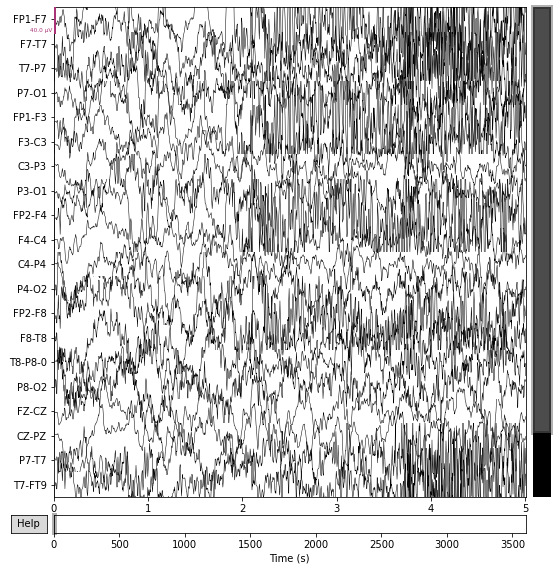

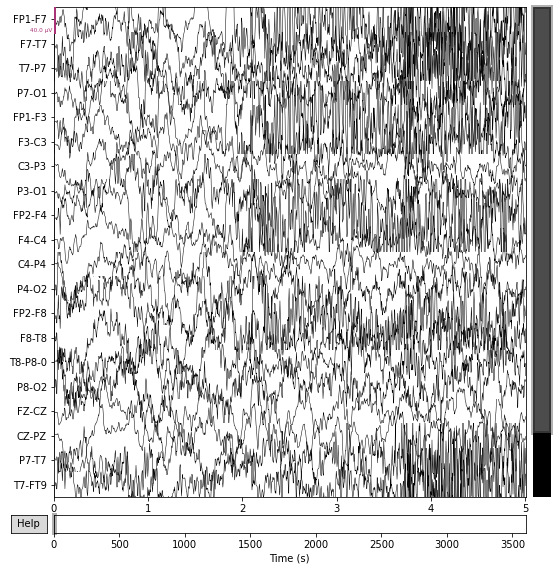

In [4]:
# draw edf
raw.plot(duration=5)

In [5]:
# time indexing epoch (0-30 sec)
raw_epoch = raw.copy().crop(0, 30, include_tmax=False).load_data().notch_filter(freqs=60.0)

Reading 0 ... 7679  =      0.000 ...    29.996 secs...
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1691 samples (6.605 sec)



In [6]:
# extract data by ndarray
raw_selection = raw_epoch.get_data();raw_selection.shape

(23, 7680)

### 23 Channel's EEG of a Patients

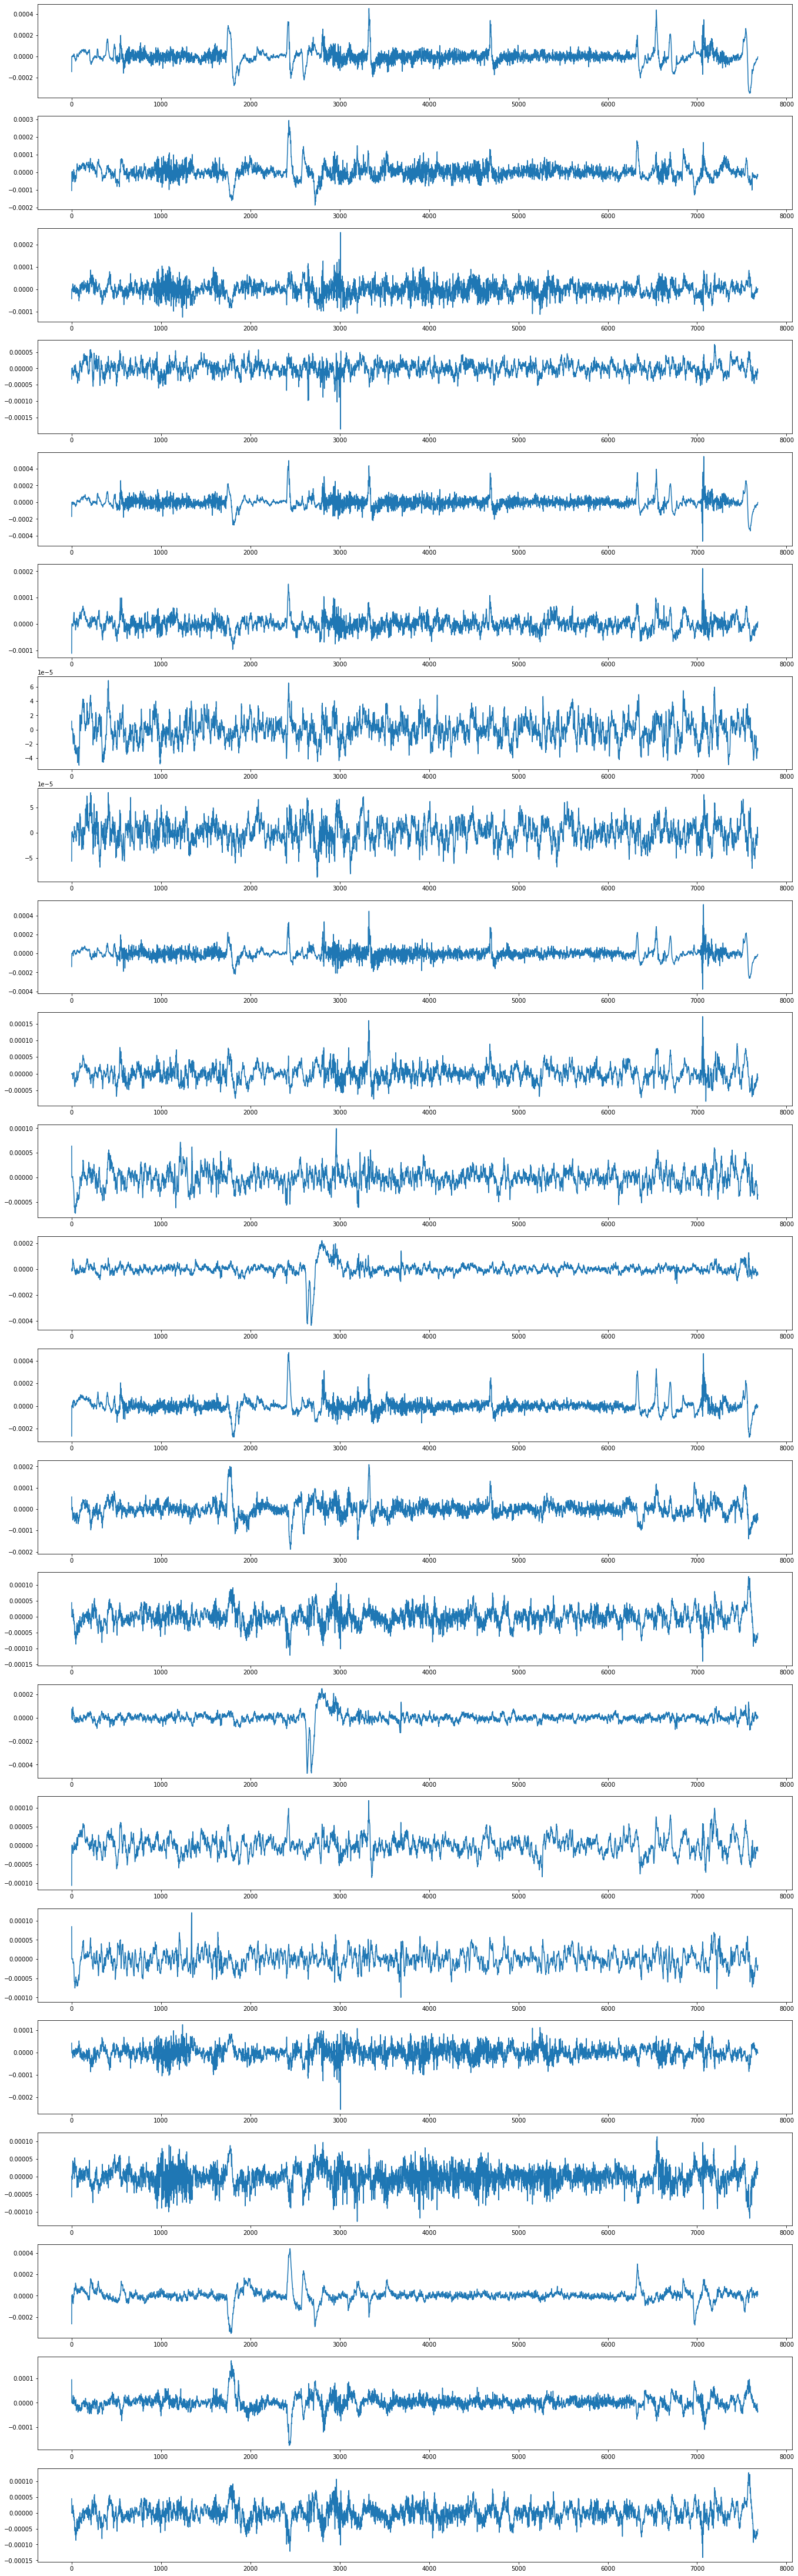

In [10]:
# draw a plot of raw-signal by selected electrode
plt.figure(figsize=(23, 80)) 
for i in range(raw_selection.shape[0]):
    plt.subplot(23,1,i+1)
    x = raw_selection[i]
    plt.plot(x)

### 2. Signal Processing

#### 1) Band-pass filtering

In [14]:
from scipy.signal import butter
from scipy.signal import filtfilt

In [15]:
# sampling frequency
fs = raw.info['sfreq']
# mininum pass frequency (fmax)
lowcut = 1
# maximum pass frequency (fmax)
highcut = 30
# order
order = 3

In [17]:
# band-pass filtering range from fmin to fmax
nyq = 0.5 * fs
low = lowcut / nyq
high = highcut / nyq
b, a = butter(order, [low, high], btype='band')
y = filtfilt(b, a, x)

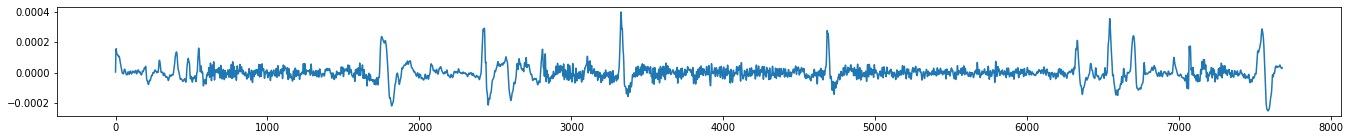

In [11]:
# draw a plot of band-pass filtered signal
plt.figure(figsize=(23, 2)) 
plt.plot(y)

#### 2) Short-time Fourier Transfrom(STFT)

In [19]:
from scipy.signal import stft 
from sklearn.preprocessing import MinMaxScaler

In [20]:
# Normalization (0-1)
# initialize scaler 
scaler = MinMaxScaler()

In [21]:
# STFT, window 1sec, overlap 50%
f, t, Zxx = stft(y, fs=fs, window='hanning', nperseg=fs, noverlap=(fs//2), boundary=None)
# absolute
Zxx = np.abs(Zxx)
# normalization
Zxx = scaler.fit_transform(10*np.log10(Zxx))

C:\Users\user\AppData\Local\Temp/ipykernel_18536/2294216312.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, Zxx, cmap='jet')


Text(0.5, 0, 'Time [sec]')

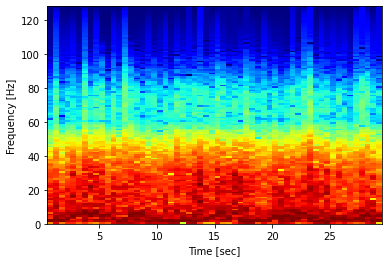

In [22]:
# draw a STFT plot
plt.pcolormesh(t, f, Zxx, cmap='jet')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

#### 3) Continuous Wavelet Transform(CWT)

In [18]:
from obspy.signal.tf_misfit import cwt

In [19]:
# declare parameters
dt = 1/fs
w0 = 2
nf = 100
fmin = lowcut
fmax = highcut

In [20]:
# CWT
scalogram = pow(np.abs(cwt(x, dt, w0, fmin, fmax, nf)), 2)

Text(0.5, 0, 'Time')

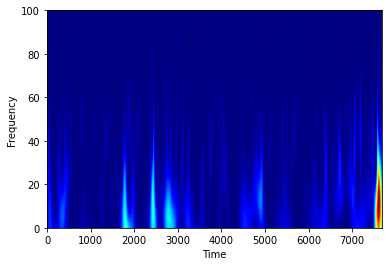

In [22]:
# draw a CWT plot
plt.pcolormesh(scalogram, cmap='jet')
plt.ylabel('Frequency')
plt.xlabel('Time')